In [17]:
import numpy as np 
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

Задание №1 - Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

In [18]:
# Подгружаем данные о регистрации и о времени захода пользователей в игру
df_reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-turov/shared/problem1-reg_data.csv', sep= ';')
df_auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-turov/shared/problem1-auth_data.csv', sep= ';')

In [19]:
# Проверяем датафремы df_reg и df_auth на наличие пропусков и дубликатов
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [20]:
duplicates_reg = df_reg[df_reg.duplicated()]

print(duplicates_reg)

Empty DataFrame
Columns: [reg_ts, uid]
Index: []


In [21]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [22]:
duplicates_auth = df_auth[df_auth.duplicated()]

print(duplicates_auth)

Empty DataFrame
Columns: [auth_ts, uid]
Index: []


Дубликатов и пустых значений не обнаружено. Продолжаем действия по преобразованию датафрейма и созданию когортного анализа внутри функции.

In [23]:
# Переводим дату в вид datetime из юникс-системы
df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s')
df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s')

In [24]:
df = pd.merge(df_reg, df_auth, on='uid', how='left')

Пишем функцию для расчета retention. Для визуализации retention добавлена тепловая карта и когортный анализ.

In [26]:
def calculate_full_retention (df_reg, df_auth, start=None, end=None):
    """
    Рассчитывает полный retention игроков по дням от даты регистрации с когортным анализом и тепловой картой.

    Параметры:
    - df_reg: DataFrame с данными о регистрации пользователей.
    - df_auth: DataFrame с данными о времени захода пользователей в игру.
    - start: Начальная дата для подсчета retention (формат: YYYY-MM-DD).
    - end: Конечная дата для подсчета retention (формат: YYYY-MM-DD).

    Возвращает:
    - cohorts: DataFrame с результатами когортного анализа.
    """

    # Проверяем наличие столбцов
    required_columns_reg = {'reg_ts', 'uid'}
    required_columns_auth = {'auth_ts', 'uid'}

    # Преобразуем временные метки в формат datetime
    df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s')
    df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s')

    # Фильтруем данные по заданному диапазону дат
    if start:
        df_reg = df_reg[df_reg['reg_ts'] >= pd.to_datetime(start)]
        df_auth = df_auth[df_auth['auth_ts'] >= pd.to_datetime(start)]
    if end:
        df_reg = df_reg[df_reg['reg_ts'] <= pd.to_datetime(end)]
        df_auth = df_auth[df_auth['auth_ts'] <= pd.to_datetime(end)]

    df = pd.merge(df_reg, df_auth, on='uid', how='left')

    # Рассчитываем количество дней от начальной даты для каждой строки
    df['day'] = (df['auth_ts'] - df['reg_ts']).dt.days

    # Когортный анализ
    df['reg_date'] = df['reg_ts'].dt.date
    cohorts = df.groupby(['reg_date', 'day']).agg({'uid': 'nunique'}).reset_index()
    cohorts['retention'] = cohorts.groupby('reg_date')['uid'].transform(lambda x: x / x.iloc[0])

    # Построение тепловой карты
    cohort_pivot = cohorts.pivot(index='reg_date', columns='day', values='retention')
    plt.figure(figsize=(14, 8))
    sns.heatmap(cohort_pivot, annot=True, fmt='.2f', cmap='viridis')
    plt.title('Cohort Analysis - Retention Heatmap')
    plt.xlabel('Days')
    plt.ylabel('Registration Date')
    plt.show()

    return cohorts

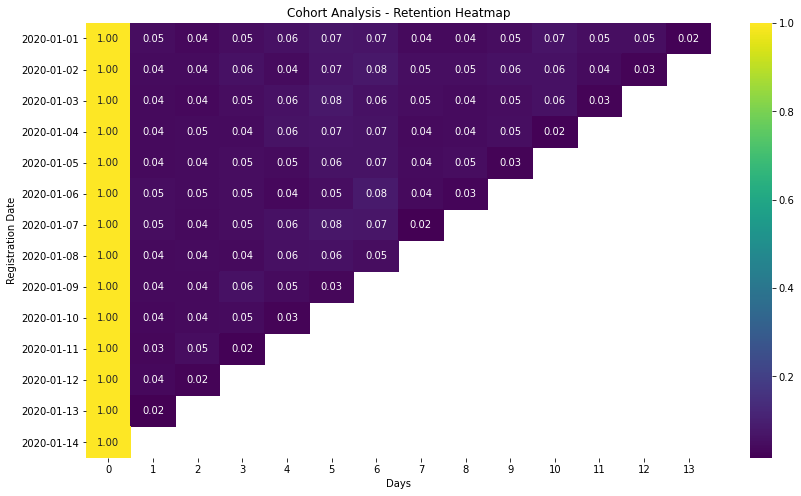

       reg_date  day   uid  retention
0    2020-01-01    0  1061   1.000000
1    2020-01-01    1    50   0.047125
2    2020-01-01    2    38   0.035815
3    2020-01-01    3    51   0.048068
4    2020-01-01    4    62   0.058435
..          ...  ...   ...        ...
100  2020-01-12    1    42   0.038853
101  2020-01-12    2    27   0.024977
102  2020-01-13    0  1083   1.000000
103  2020-01-13    1    21   0.019391
104  2020-01-14    0  1084   1.000000

[105 rows x 4 columns]


In [27]:
# Пример использования функции
start_date = '2020-01-01'
end_date = '2020-01-15'

retention_data = calculate_full_retention (df_reg, df_auth, start=start_date, end=end_date)
print(retention_data)

По результатам визуализации, можно сделать вывод, что retention в приложении низкий. Для выявления причин низкого retention может понадобиться дополнительное исследование продукта, дать точный ответ невозможно. 

Для повышения уровня retention необходимо после проведения дополнительного исследования продукта, разработать план, предполагающий:

1. Составление PMF и нахождение новых и эффективных PMC;
2. Выявление неэффективных PMC и переорганизация ресурсов, которые шли на их содержаие. 

Задание №2. Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [28]:
# Загружаем данные и разделяем колонки
df_apru = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-turov/Final_project/var_1.csv', sep=';')

In [29]:
# Переводим колонку revenue в формат int
df_apru['revenue'] = df_apru['revenue'].astype(int)

In [30]:
# Проверяем датафрейм
df_apru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [31]:
# Смотрим на наличие пустых значений
df.isna().sum()

reg_ts     0
uid        0
auth_ts    0
dtype: int64

In [32]:
# Группируем по группам и считаем общую прибыль
df_apru_a = df_apru.groupby('testgroup').agg({'revenue': 'sum'})
print(df_apru_a)

           revenue
testgroup         
a          5136189
b          5421603


In [33]:
# Группируем по группам и считаем кол-во уникальных пользователей
df_apru_a = df_apru.groupby('testgroup').agg({'user_id': 'nunique'})
print(df_apru_a)

           user_id
testgroup         
a           202103
b           202667


In [34]:
# Фильтруем пользователей и выбираем только платящих
df_apru_payusers = df_apru.query('revenue > 0').groupby('testgroup').agg({'user_id': 'nunique'})
print(df_apru_payusers)

           user_id
testgroup         
a             1928
b             1805


In [35]:
# На данный момент получаются такие данные:
revenue_a = 5136189
revenue_b = 5421603
user_a_all = 202103
user_b_all = 202667
user_a_payusers = 1928
user_b_payusers = 1805

In [36]:
# Рассмотрим общие сведения по обоим группам
df_apru.query("testgroup == 'a'").describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [37]:
# Рассмотрим общие сведения по обоим группам
df_apru.query("testgroup == 'b'").describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


Стоит обратить внимание на два параметра: std (стандартное отклонение) и max (максимальная сумма покупки от пользователя). Эти два значения различаются. В группе А (контрольная группа), стандартное распределение выше, чем в группе B (тестовая группа), так же там выше максимальная сумма покупки. 

Для качественного А/B теста необходимо, чтобы все показатели были похожими. Видимо, при составлении выборки для теста были допущены нарушения и все дальнейшие результаты теста нужно ставить под сомнение. 

Посчитаем теперь ряд метрик. Помимо ARPU, желательно посчитать еще ARPPU (расчет только по платящим пользователям) и конверсию в оплату (CR). 

Посчитаем APRU. Формула = Выручка / кол-во всех пользователей в группе

In [38]:
apru_group_a = round(revenue_a / user_a_all, 2)
print(f'ARPU по контрольной (А) группе: {apru_group_a}')

apru_group_b = round(revenue_b / user_b_all, 2)
print(f'ARPU по тестовой (B) группе: {apru_group_b}')

ARPU по контрольной (А) группе: 25.41
ARPU по тестовой (B) группе: 26.75


Посчитаем ARPPU. Периодическое сравнение ARPU и ARPPU помогает понять ситуацию с доходом компании. Чем больше разница показателей, тем меньше прибыль. Формула ARPPU = Выручка / Кол-во платящих клиентов.

In [39]:
arppu_a = round(revenue_a / user_a_payusers, 2)
print(f'ARPPU по контрольной (А) группе: {arppu_a}')

arppu_b = round(revenue_b / user_b_payusers, 2)

print(f'ARPPU по тестовой (B) группе: {arppu_b}')

ARPPU по контрольной (А) группе: 2664.0
ARPPU по тестовой (B) группе: 3003.66


Посчитаем CR в покупку акционных предложений.
Формула CR = (Кол-во пользователей, совершившие покупку / Кол-во всех пользователей) * 100

In [40]:
CR_a = round((user_a_payusers / user_a_all) * 100, 2)
print(f'CR по контрольной (А) группе: {CR_a}')

CR_b = round((user_b_payusers / user_b_all) * 100, 2)
print(f'CR по тестовой (B) группе: {CR_b}')

CR по контрольной (А) группе: 0.95
CR по тестовой (B) группе: 0.89


Выводы: Значения в контрольной группе по ARPPU и CR выше, чем в тестовой. Необходимо провести ряд A/B тестов, чтобы понять статистическую значимость нововведенных акционных предложений.

Проверим ARPU.

Нулевая гипотеза - статистически значимых различий между контрольной и тестовой группы нет. 
Альтернативная гипотеза - статистически значимые различия между контрольной и тестовой группой есть. 

Проверяем дисперсии на гомогенность:

In [41]:
pg.homoscedasticity(data=df_apru, dv="revenue", group="testgroup") 

,W,pval,equal_var
levene,0.389629,0.532495,True


В значении equal_var значение True, значит дисперсии гомогенны.

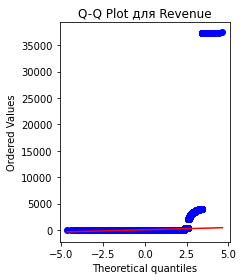

In [42]:
# Посмотрим на нормальность распределения выборок и используем Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df_apru['revenue'], dist="norm", plot=plt)
plt.title('Q-Q Plot для Revenue')

plt.tight_layout()
plt.show()

In [43]:
df_apru_users_35k = df_apru.query('revenue > 35000')
print(df_apru_users_35k)

        user_id  revenue testgroup
416         417    37324         a
4428       4429    37304         a
5777       5778    37315         a
8065       8066    37307         a
8743       8744    37334         a
...         ...      ...       ...
360696   360697    37347         a
378668   378669    37297         a
389341   389342    37298         a
394580   394581    37302         a
399294   399295    37321         a

[123 rows x 3 columns]


На графике видно, что есть выбросы данных. В случаях, когда есть выбросы данных, следует применять непараметрические методы, такие как U-критерий Манна-Уитни. Пользователей, с которых мы получили большую прибыль 123 человека (причины могут быть разные: заядлые игроки или крупный донат). Но раз выборки большие, то распределение средних будет стремиться к нормальному, а значит можно использовать t-криетерий. 

In [44]:
df_apru_group_a = df_apru[df_apru['testgroup'] == 'a']
df_apru_group_b = df_apru[df_apru['testgroup'] == 'b']

In [45]:
pg.ttest(df_apru_group_a.revenue, df_apru_group_b.revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


p-value равняется 0.532965 (больше 0.05), а значит нулевая гипотеза не отклоняется.

Теперь проверим ARPPU. 

Нулевая гипотеза - статистически значимых различий между контрольной и тестовой группы нет. Альтернативная гипотеза - статистически значимые различия между контрольной и тестовой группой есть.

Проверяем дисперсии на гомогенность:

In [46]:
df_apru_revenue_plus = df_apru[df_apru ['revenue'] > 0]

In [47]:
pg.homoscedasticity(data=df_apru_revenue_plus, dv="revenue", group="testgroup") 

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


В значении equal_var значение False, значит дисперсии негомогенны и применять t-критерий как в случае с ARPU мы не можем. Применим t-критерий Уэлча, который корректирует степени свободы и стандартную ошибку, чтобы учесть неравенство дисперсий.

In [48]:
pg.ttest(df_apru_group_a[df_apru_group_a['revenue'] > 0]['revenue'], df_apru_group_b[df_apru_group_b['revenue'] > 0]['revenue'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


p-value равняется 0.100208 (больше 0.05), а значит нулевая гипотеза не отклоняется.

Теперь проверим конверсию (CR). 

Нулевая гипотеза - статистически значимых различий между контрольной и тестовой группы нет. Альтернативная гипотеза - статистически значимые различия между контрольной и тестовой группой есть.

В отличии от первых двух тестов, здесь можно использовать хи-квадрат, ибо у пользователя на выбор есть несколько вариантов (совершать покупку или нет).

При этом нужно добавить новый столбец, который будет делать пометку - пользователь входит в группу платящего или нет.

In [49]:
# Добавляем новый столбец puser и с помощью функции where определяем, если revenue больше 0, то ставим 1. Если меньше, то ставим 0
df_apru['puser'] = np.where(df_apru['revenue'] > 0, 1, 0)
df_apru

,user_id,revenue,testgroup,puser
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [50]:
stats.chi2_contingency(pd.crosstab(df_apru.testgroup, df_apru.puser)) 

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

p-value равняется  0.03647561892312613, что меньше 0.05 и значит есть статистически значимые различия. 

Выводы: 
Были подсчитаны три метрики: ARPU, ARPPU и CR;
Были проведены три статистических теста: t-критерий, t-критерий Уэлча и хи-квадрат. В первых двух p-value было больше 0.05, в последнем p-value меньше 0.05;

Какой набор предложений можно считать лучшим?
Отвечая на главный вопрос задания, нужно учитывать факт того, какое стандартное отклонение было у данных. На мой взгляд, необходимо перепроверить данные и провести А/В тестирование повторно, если есть такая возможность и сделать более строгий контроль над сбором сведений. 

Если же такой возможности нет, то статистически значимые значения есть только в CR, даже не смотря на то, что ARPU в тестовой группе был на 5% больше. Учитывая, все вышеперечисленное и плюс ситуацию с выбросом данных, которые необходимо проанализировать дополнительно и узнать их причину - акционные предложения лучше не вводить, так как контрольная группа давала более положительные результаты в рамках исследования.

Задание №3. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Для ответа на вопрос о том, как можно оценить результаты последнего прошедшего события, стоит рассмотреть ряд метрик. 

1. Метрики привлечения.
Предположим, у компании есть маркетинговый отдел, который занимается рекламной кампанией нового ивента. Это можно использовать, чтобы определить кол-во людей, которые приняли участие в ивенте. 

Стоимость одной установки (CPI) (да, в условии задания не сказано про стоимость рекламной кампании, но предположим, она была) = общая стоимость рекламной компании / кол-во новых пользователей, которые зарегистрировались на событие.


Конверсия в регистрацию на событие (CR) = (кол-во пользователей, зарегистравившихся на событие / кол-во всех пользователей) * 100

ARPU (Average Revenue Per User) = общий доход за период / на количество пользователей за этот же период. 
Пользователи, которые попали на ежемесечный ивент могут приобрести виртуальную валюту/предметы/подписку. В задаче нет условий о том, что ивент доступен по подписке, но и такой вариант тоже может быть. 

2. Метрики вовлеченности. 
Название самой группы метрик говорит за себя - они помогают измерить вовлеченность пользователей в продукт.

MAU - учитывая, что у нас ежемесячные ивенты, то здесь больше подходит MAU. Эта одна из основных метрик, отвечающая на главный вопрос задачи - оценка прошедшего события. Если MAU больше 20%, то ивент собрал значительное кол-во пользователей в игре. 

Retention Rate - метрика, показывающая процент удержания пользователей в продукте. Учитывая, что у нас мобильное приложение, которое устраивает постоянные ежемесячные ивенты, подобная метрика должна быть использована. 

Retention Rate = количество активных пользователей, продолжающих играть / общее количество активных пользователей в начале периода = коэффициент удержания.

3. Метрики производительности.

Эти метрики ничто иное, как показатели эффективности и используются для измерения поведения, деятельности и результативности бизнеса. Учитывая, что у нас, как у бизнеса есть задача по расширению аудитории, важно учитывать ряд технических метрик.

Время загрузки приложения (App Load Time) - важно понимать, что при увеличении объема пользователей, приложение будет работать корректно и справится с внезапной нагрузкой на сервера.

4. Дополнительные метрики

DAU (Daily Active Users) - количество пользователей, активных ежедневно. Это поможет понять, насколько часто пользователи возвращаются в игру во время события.

Среднее время в игре (Average Session Duration) - время, которое пользователи проводят в игре за одну сессию. Это может дать представление о том, насколько увлекательно событие.

Отзывы и рейтинги. Анализ отзывов и рейтингов пользователей в магазинах приложений может дать качественную оценку удовлетворенности пользователей.

Таким образом, отвечая на первый вопрос задачи, можно выделить метрики:
Конверсия в регистрацию на событие (CR)
ARPU
MAU
Retention Rate
Average Session Duration

Посмотрев на результаты этих метрик, можно сделать вывод о том, было ли событие проведено успешно как с точки зрения финансовой, так и с удовлетворенности пользователей (пользователь удовлетворен = пользователь продолжает заходить в игру).

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Да, изменится. Пользователь после нескольких неудачных попыток может и вовсе не вернуться в игру. Здесь, на мой взгляд, стоит рассмотреть еще Churn Rate.

Churn Rate = (Количество ушедших пользователей после начала ивента / Первоначальное количество пользователей) * 100

Внимательно стоит смотреть за тем, как будет меняться Retention Rate. Если возникнет ситуация с тем, что пользователи начнут покидать игру и более не возвращаться, процент удержания снизится.
И это конечно же так же отразится на ARPU - пользователи могут перестать покупать подписку/внутриигровые предметы. 

К тому же, можно более углубленно изучить игровые особенности и перенести их на пример метрик. Например:

1. Время на прохождение уровня.

Среднее время, которое требуется пользователям для прохождения уровня. Это поможет оценить, насколько увлекательной остается игра с новой механикой.

2. Процент успешных прохождений.

Процент пользователей, успешно прошедших уровень с первой попытки или после нескольких попыток. Это даст представление о том, насколько реалистична новая механика.

После анализа данных метрик, можно сделать вывод о том, как повлияли новые механики на пользовательский опыт.